In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

For this section, I’m going to explore a dataset from the US Geologic Survey that deals with river
flow of a river in Utah called the Dirty Devil river15.
This data is a tab-delimited ASCII file in detail described here16.
The columns are:
- agency_cd - Agency collecting data
- site_no - USGS identification number of site
- datetime - Date
- tz_cd - Timezone
- 144166_00060 - Discharge (cubic feet per second)
- 144166_00060_cd - Status of discharge. ”A” (approved), ”P” (provisional), ”e” (estimate).
- 144167_00065 - Gage height (feet)
- 144167_00065_cd - Status of gage_height. ”A” (approved), ”P” (provisional), ”e” (estimate).

In [43]:
df_url = '../data/dirtydevil.txt'

df = (
        # Read the file
        pd.read_csv(df_url, sep="\t", header=34)
        # Ignore the first row
       [1:]   
    )

df.head()

C:\Users\INNO\AppData\Local\Temp\ipykernel_30580\401033113.py:5: DtypeWarning: Columns (1,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(df_url, sep="\t", header=34)


,agency_cd,site_no,datetime,tz_cd,144166_00060,144166_00060_cd,144167_00065,144167_00065_cd
1,USGS,09333500,2001-05-07 01:00,MDT,71.0,A:[91],NaN,NaN
2,USGS,09333500,2001-05-07 01:15,MDT,71.0,A:[91],NaN,NaN
3,USGS,09333500,2001-05-07 01:30,MDT,71.0,A:[91],NaN,NaN
4,USGS,09333500,2001-05-07 01:45,MDT,70.0,A:[91],NaN,NaN
5,USGS,09333500,2001-05-07 02:00,MDT,70.0,A:[91],NaN,NaN


In [44]:
def tweak_river(df_):
    return(
        df_
        # Convert the datetime column to datetime using numeric and not TZ offsets
        .assign(datetime = pd.to_datetime(
                                            df_['datetime'] + ' ' + 
                                            df_.tz_cd.str.replace('MST', '-0700')
                                            .str.replace('MDT', '-0600'),
                                            format='%Y-%m-%d %H:%M %z',
                                            utc=True   
                                         ))
        # Rename essential column names
        .rename(columns={
            '144166_00060': 'cfs',
            '144167_00065': 'gage_height'
        })
        .set_index('datetime')
    )

In [45]:
cleaned_df = tweak_river(df)

cleaned_df.head()

,agency_cd,site_no,tz_cd,cfs,144166_00060_cd,gage_height,144167_00065_cd
datetime,,,,,,,
2001-05-07 07:00:00+00:00,USGS,09333500,MDT,71.0,A:[91],NaN,NaN
2001-05-07 07:15:00+00:00,USGS,09333500,MDT,71.0,A:[91],NaN,NaN
2001-05-07 07:30:00+00:00,USGS,09333500,MDT,71.0,A:[91],NaN,NaN
2001-05-07 07:45:00+00:00,USGS,09333500,MDT,70.0,A:[91],NaN,NaN
2001-05-07 08:00:00+00:00,USGS,09333500,MDT,70.0,A:[91],NaN,NaN


In [46]:
# Working with timezones

def to_america_denver_time(df_, time_col, tz_col):
    return(
        df_
        .assign(
                **{tz_col: df_[tz_col].replace('MDT', 'MST7MDT')}
               )
        .groupby(tz_col)
        [time_col]
        .transform(lambda s: pd.to_datetime(s)
            .dt.tz_localize(s.name, ambiguous=True)          
            .dt.tz_convert('America/Denver')
                  )
    )

## Exploring the Data

<AxesSubplot:xlabel='datetime'>

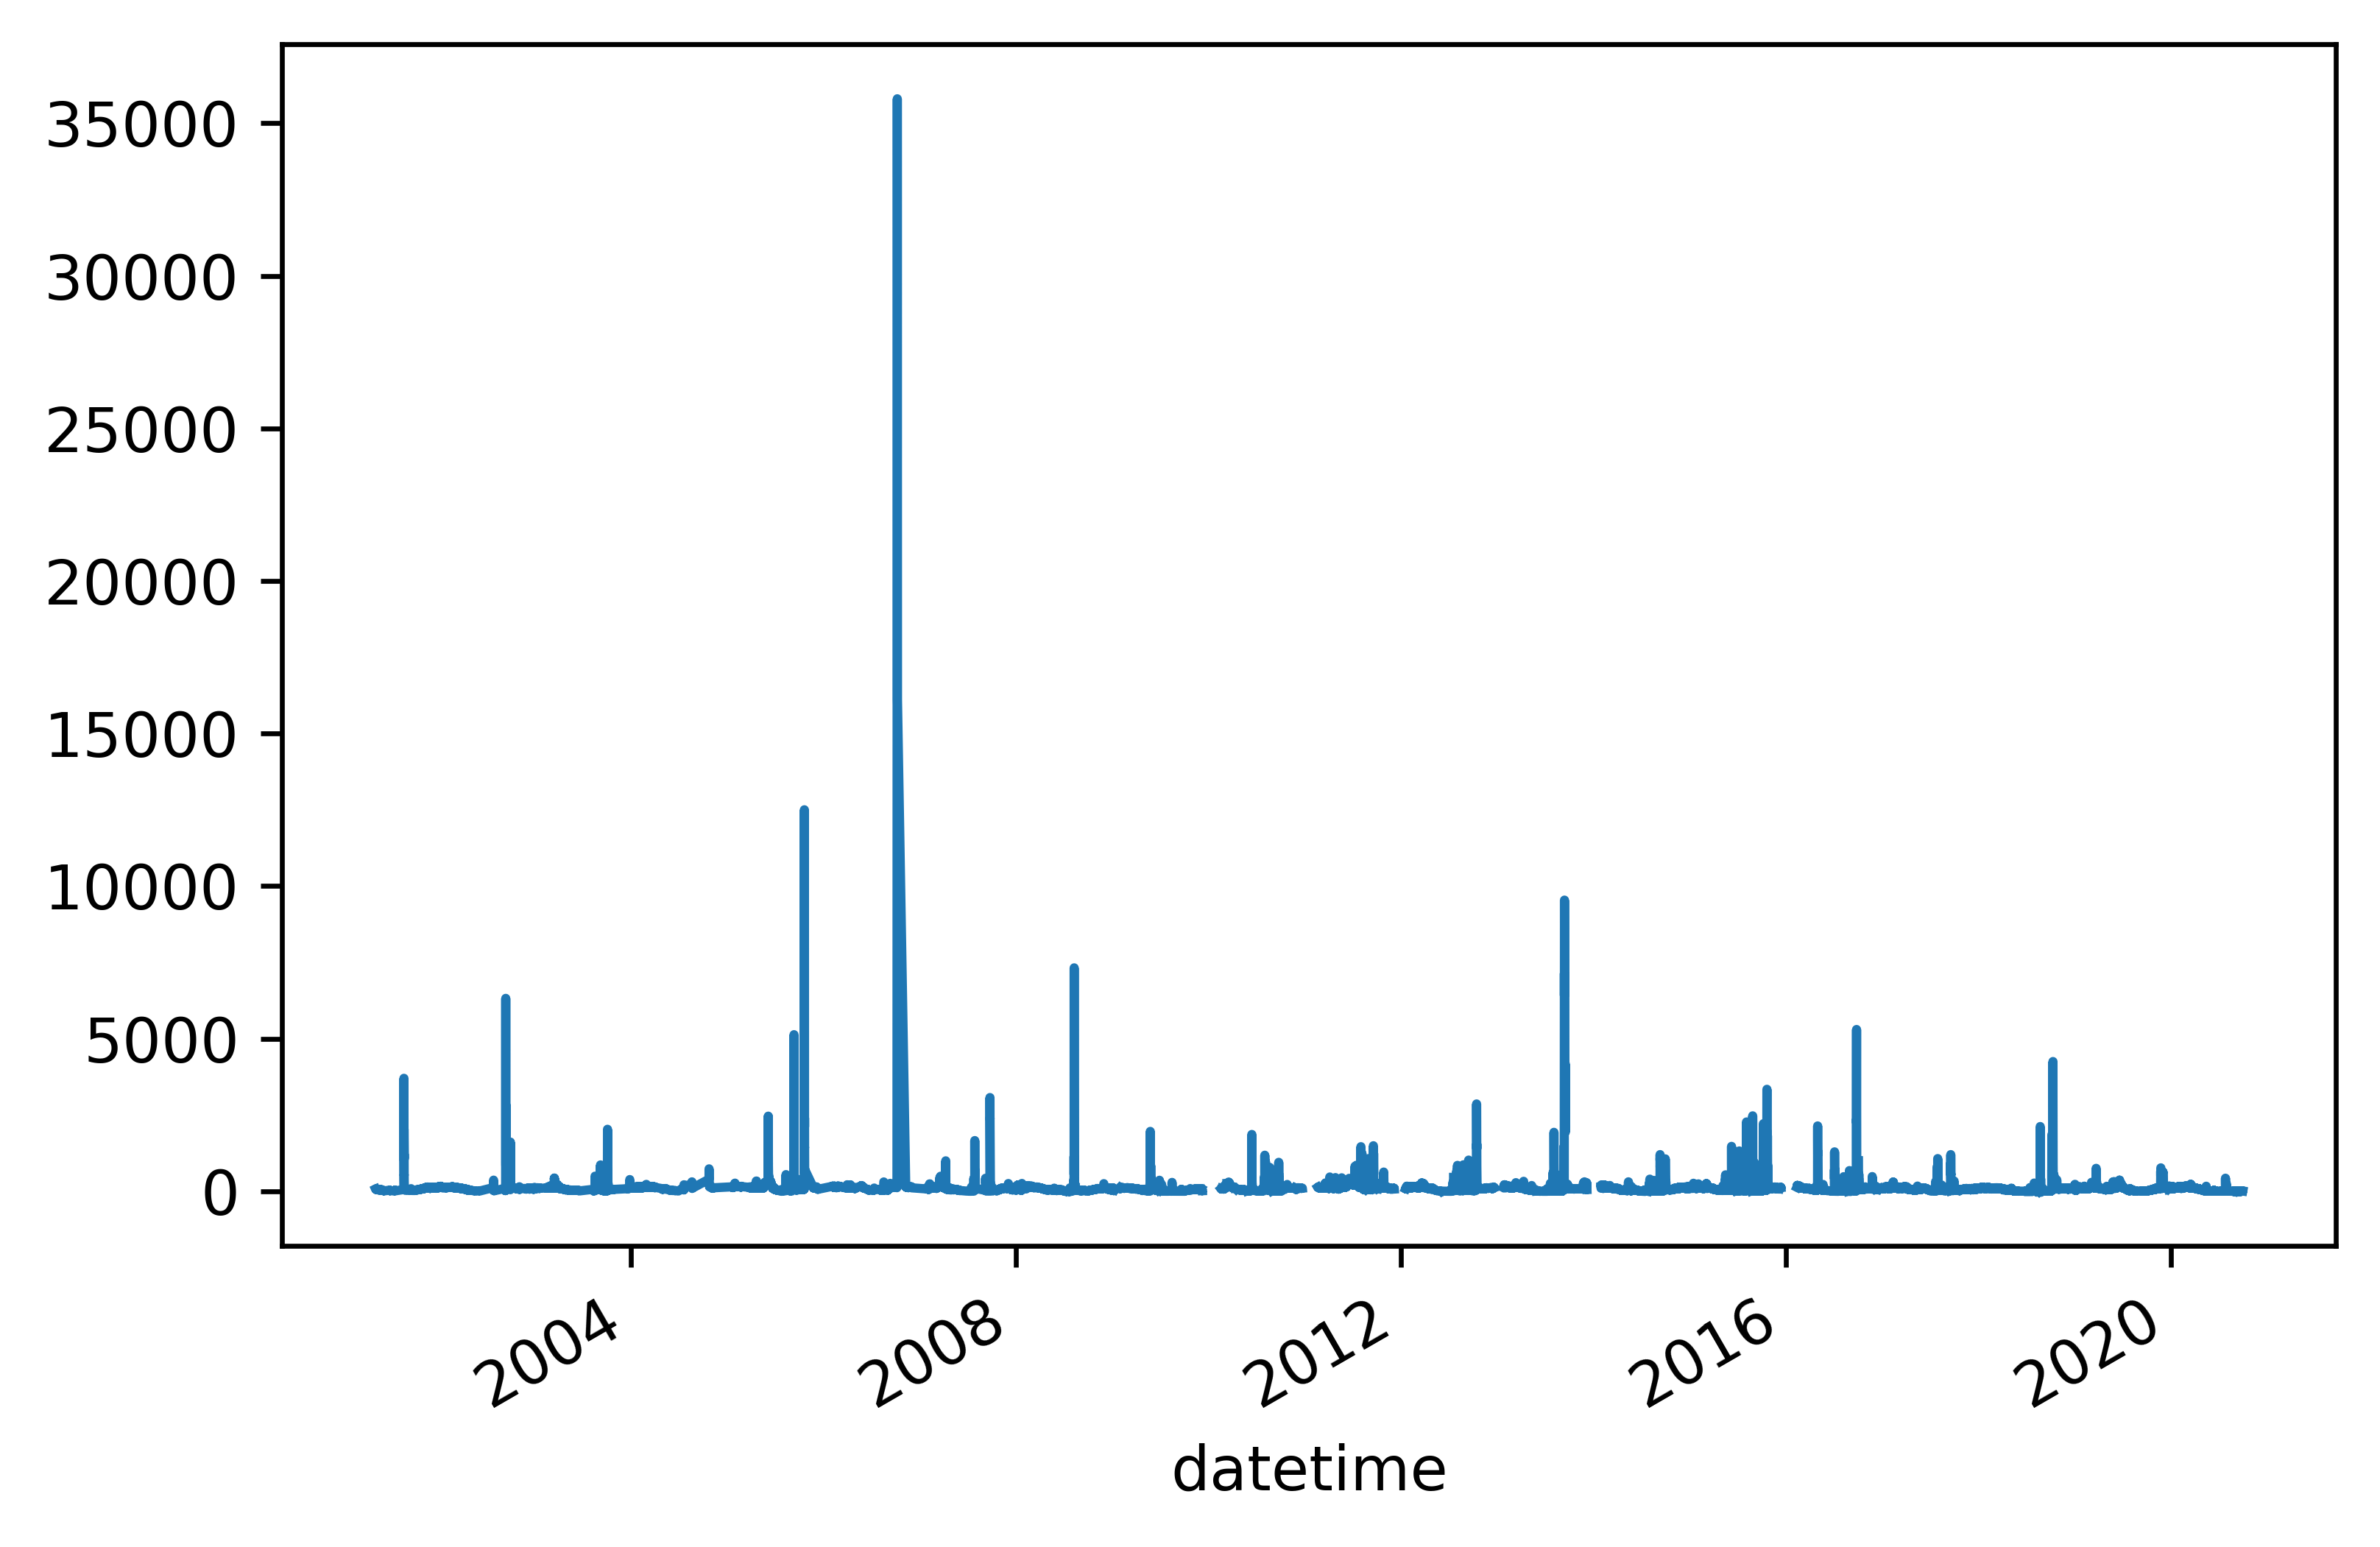

In [47]:
fig, ax = plt.subplots(dpi=600)

cleaned_df['cfs'].astype(float).plot()

In [48]:
# Describe the cfs series

cleaned_df['cfs'].astype(float).describe()

count    493124.000000
mean        104.460537
std         477.341329
min           0.000000
25%          34.700000
50%          81.000000
75%         115.000000
max       35800.000000
Name: cfs, dtype: float64

## Slicing Time Series


In [49]:
(
    cleaned_df
    ['cfs']
    # Select dates from 2018
    .loc['2018':]
)

datetime
2018-01-01 00:00:00+00:00     98.5
2018-01-01 00:15:00+00:00     98.5
2018-01-01 00:30:00+00:00    102.0
2018-01-01 00:45:00+00:00     99.7
2018-01-01 01:00:00+00:00    101.0
                             ...  
2020-09-28 14:30:00+00:00     9.53
2020-09-28 14:45:00+00:00      9.2
2020-09-28 15:00:00+00:00      9.2
2020-09-28 15:15:00+00:00      9.2
2020-09-28 15:30:00+00:00      9.2
Name: cfs, Length: 95914, dtype: object

> We can include month information as well. When you specify just the month on an end slice, it
includes all entries from that month on both the start and end slices (which has different behavior
than both partial string slicing with .loc and position slicing with .iloc):

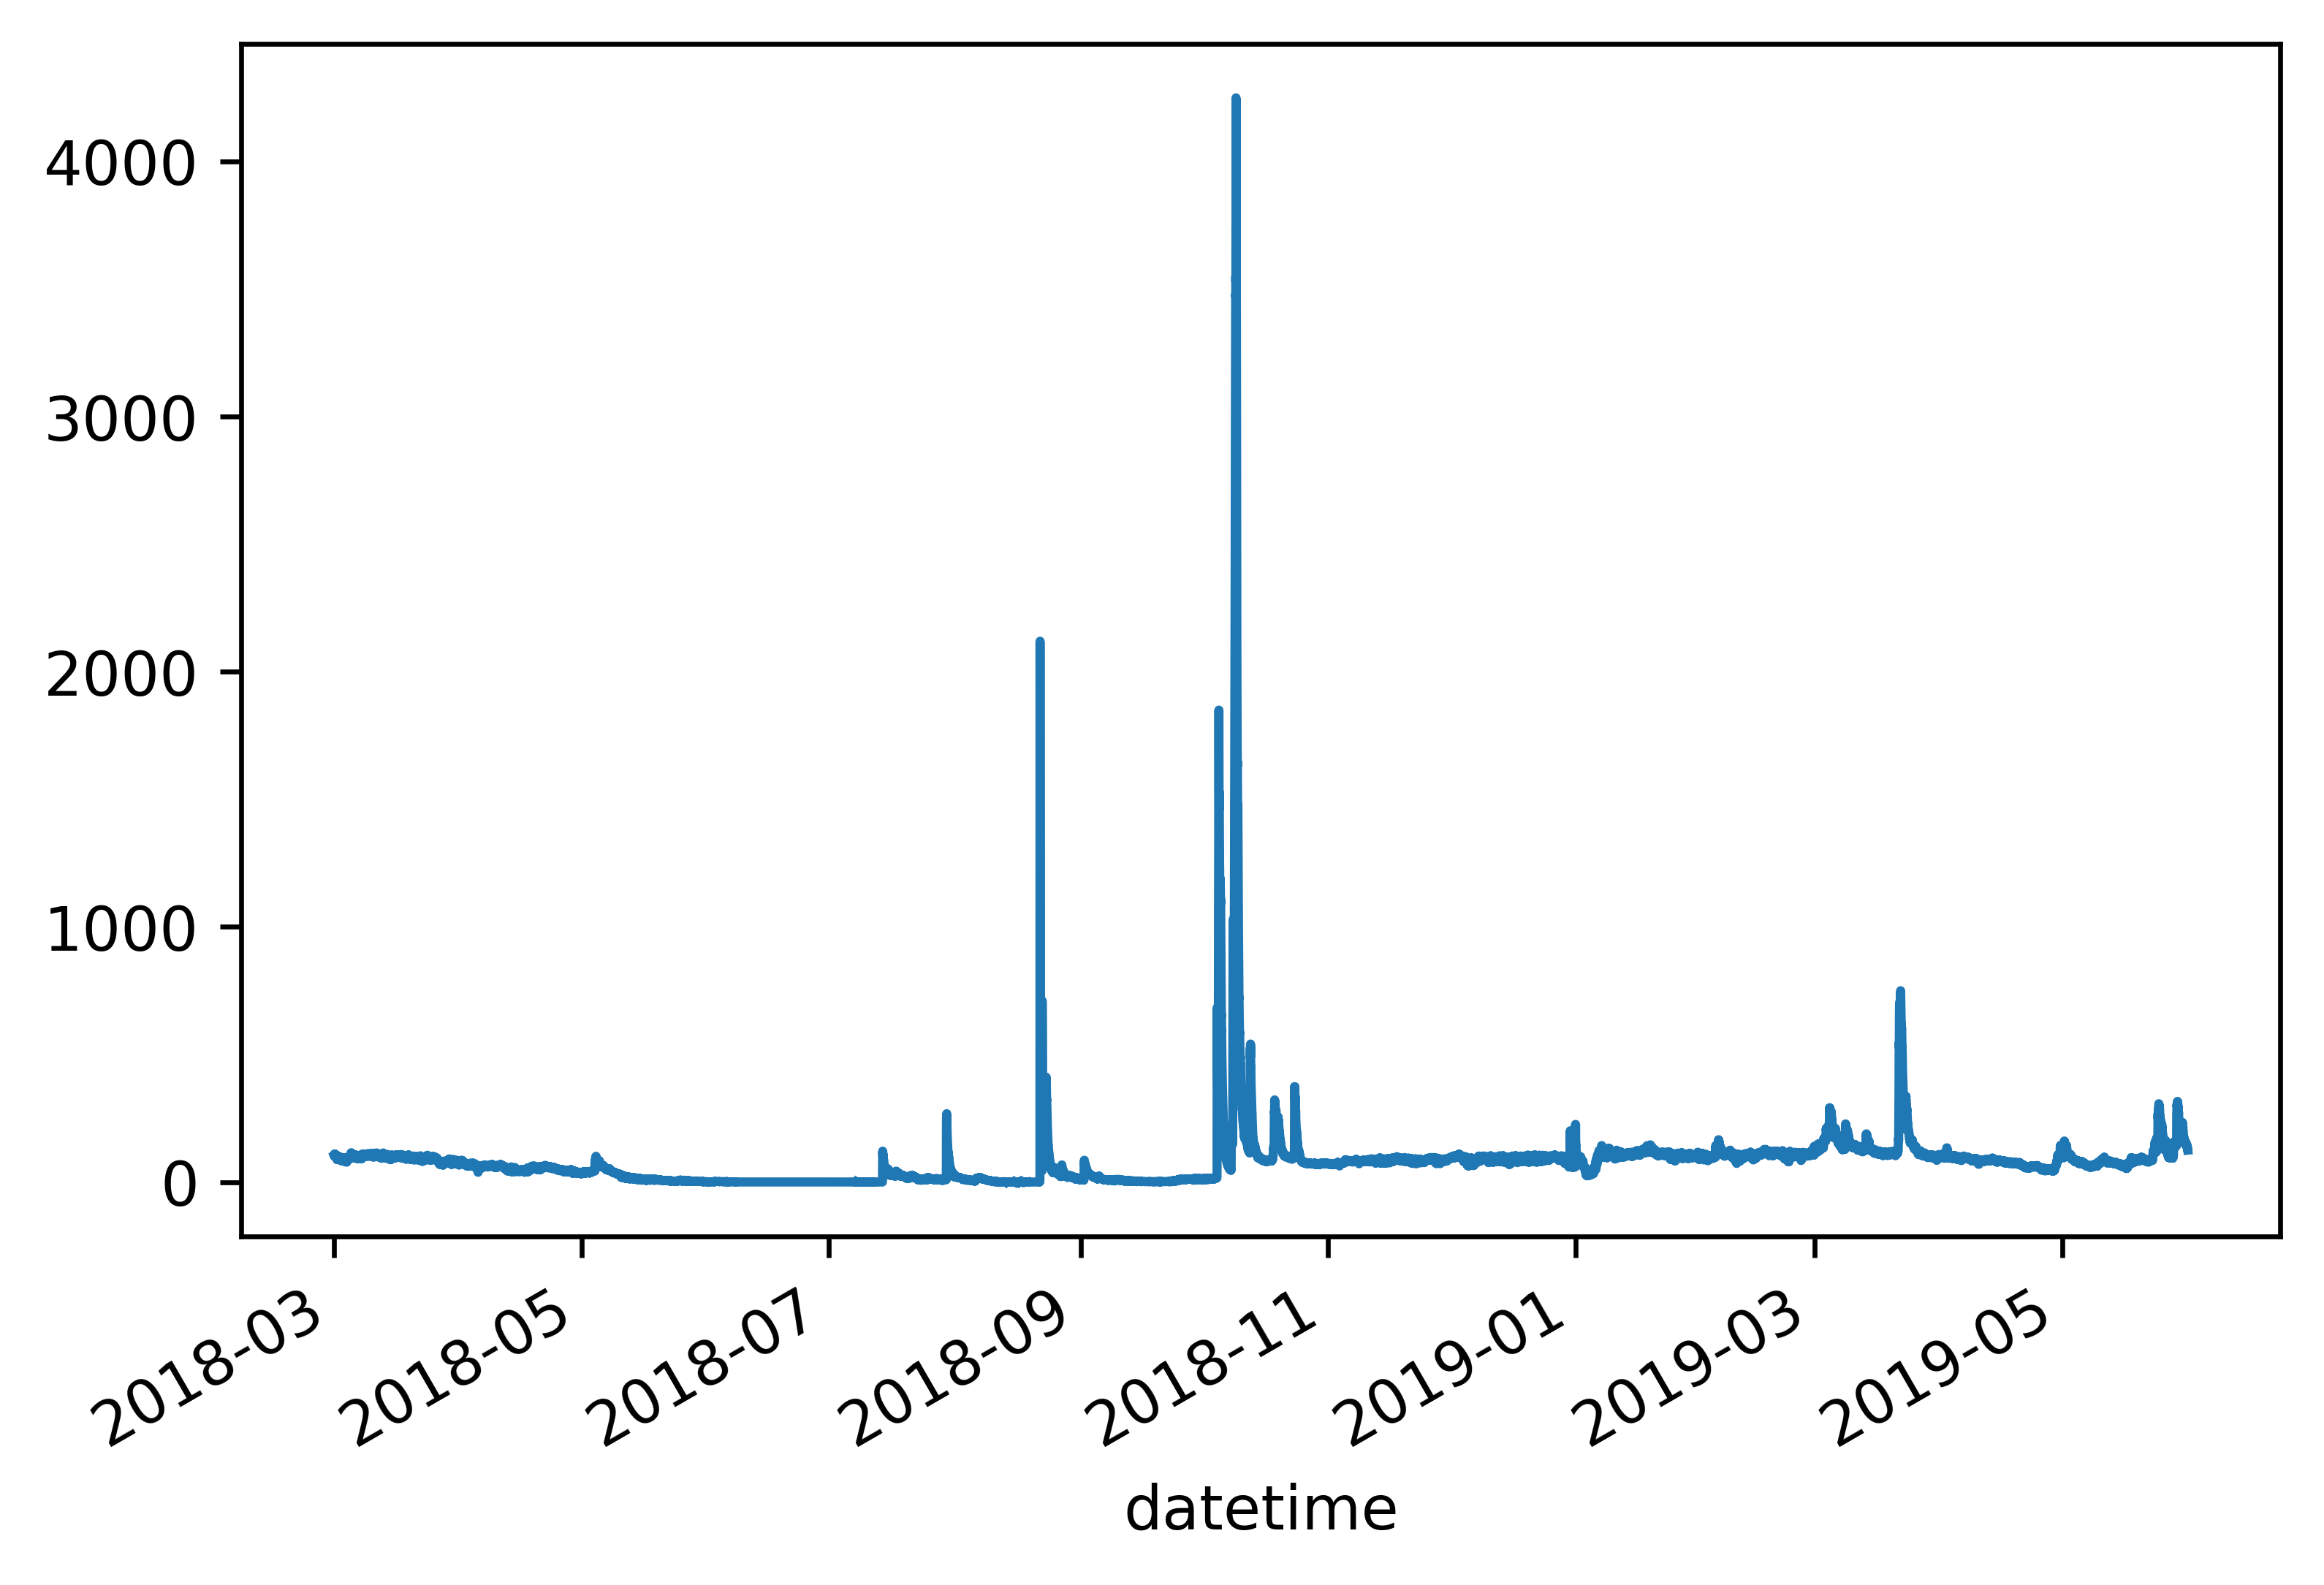

In [50]:
# Including month information
fig, ax = plt.subplots(dpi=600)
(
    cleaned_df
    ['cfs']
    # Select information from 2018/3 to 2019/5
    .loc['2018/3':'2019/5']
    # Plot this information
    .plot()
);

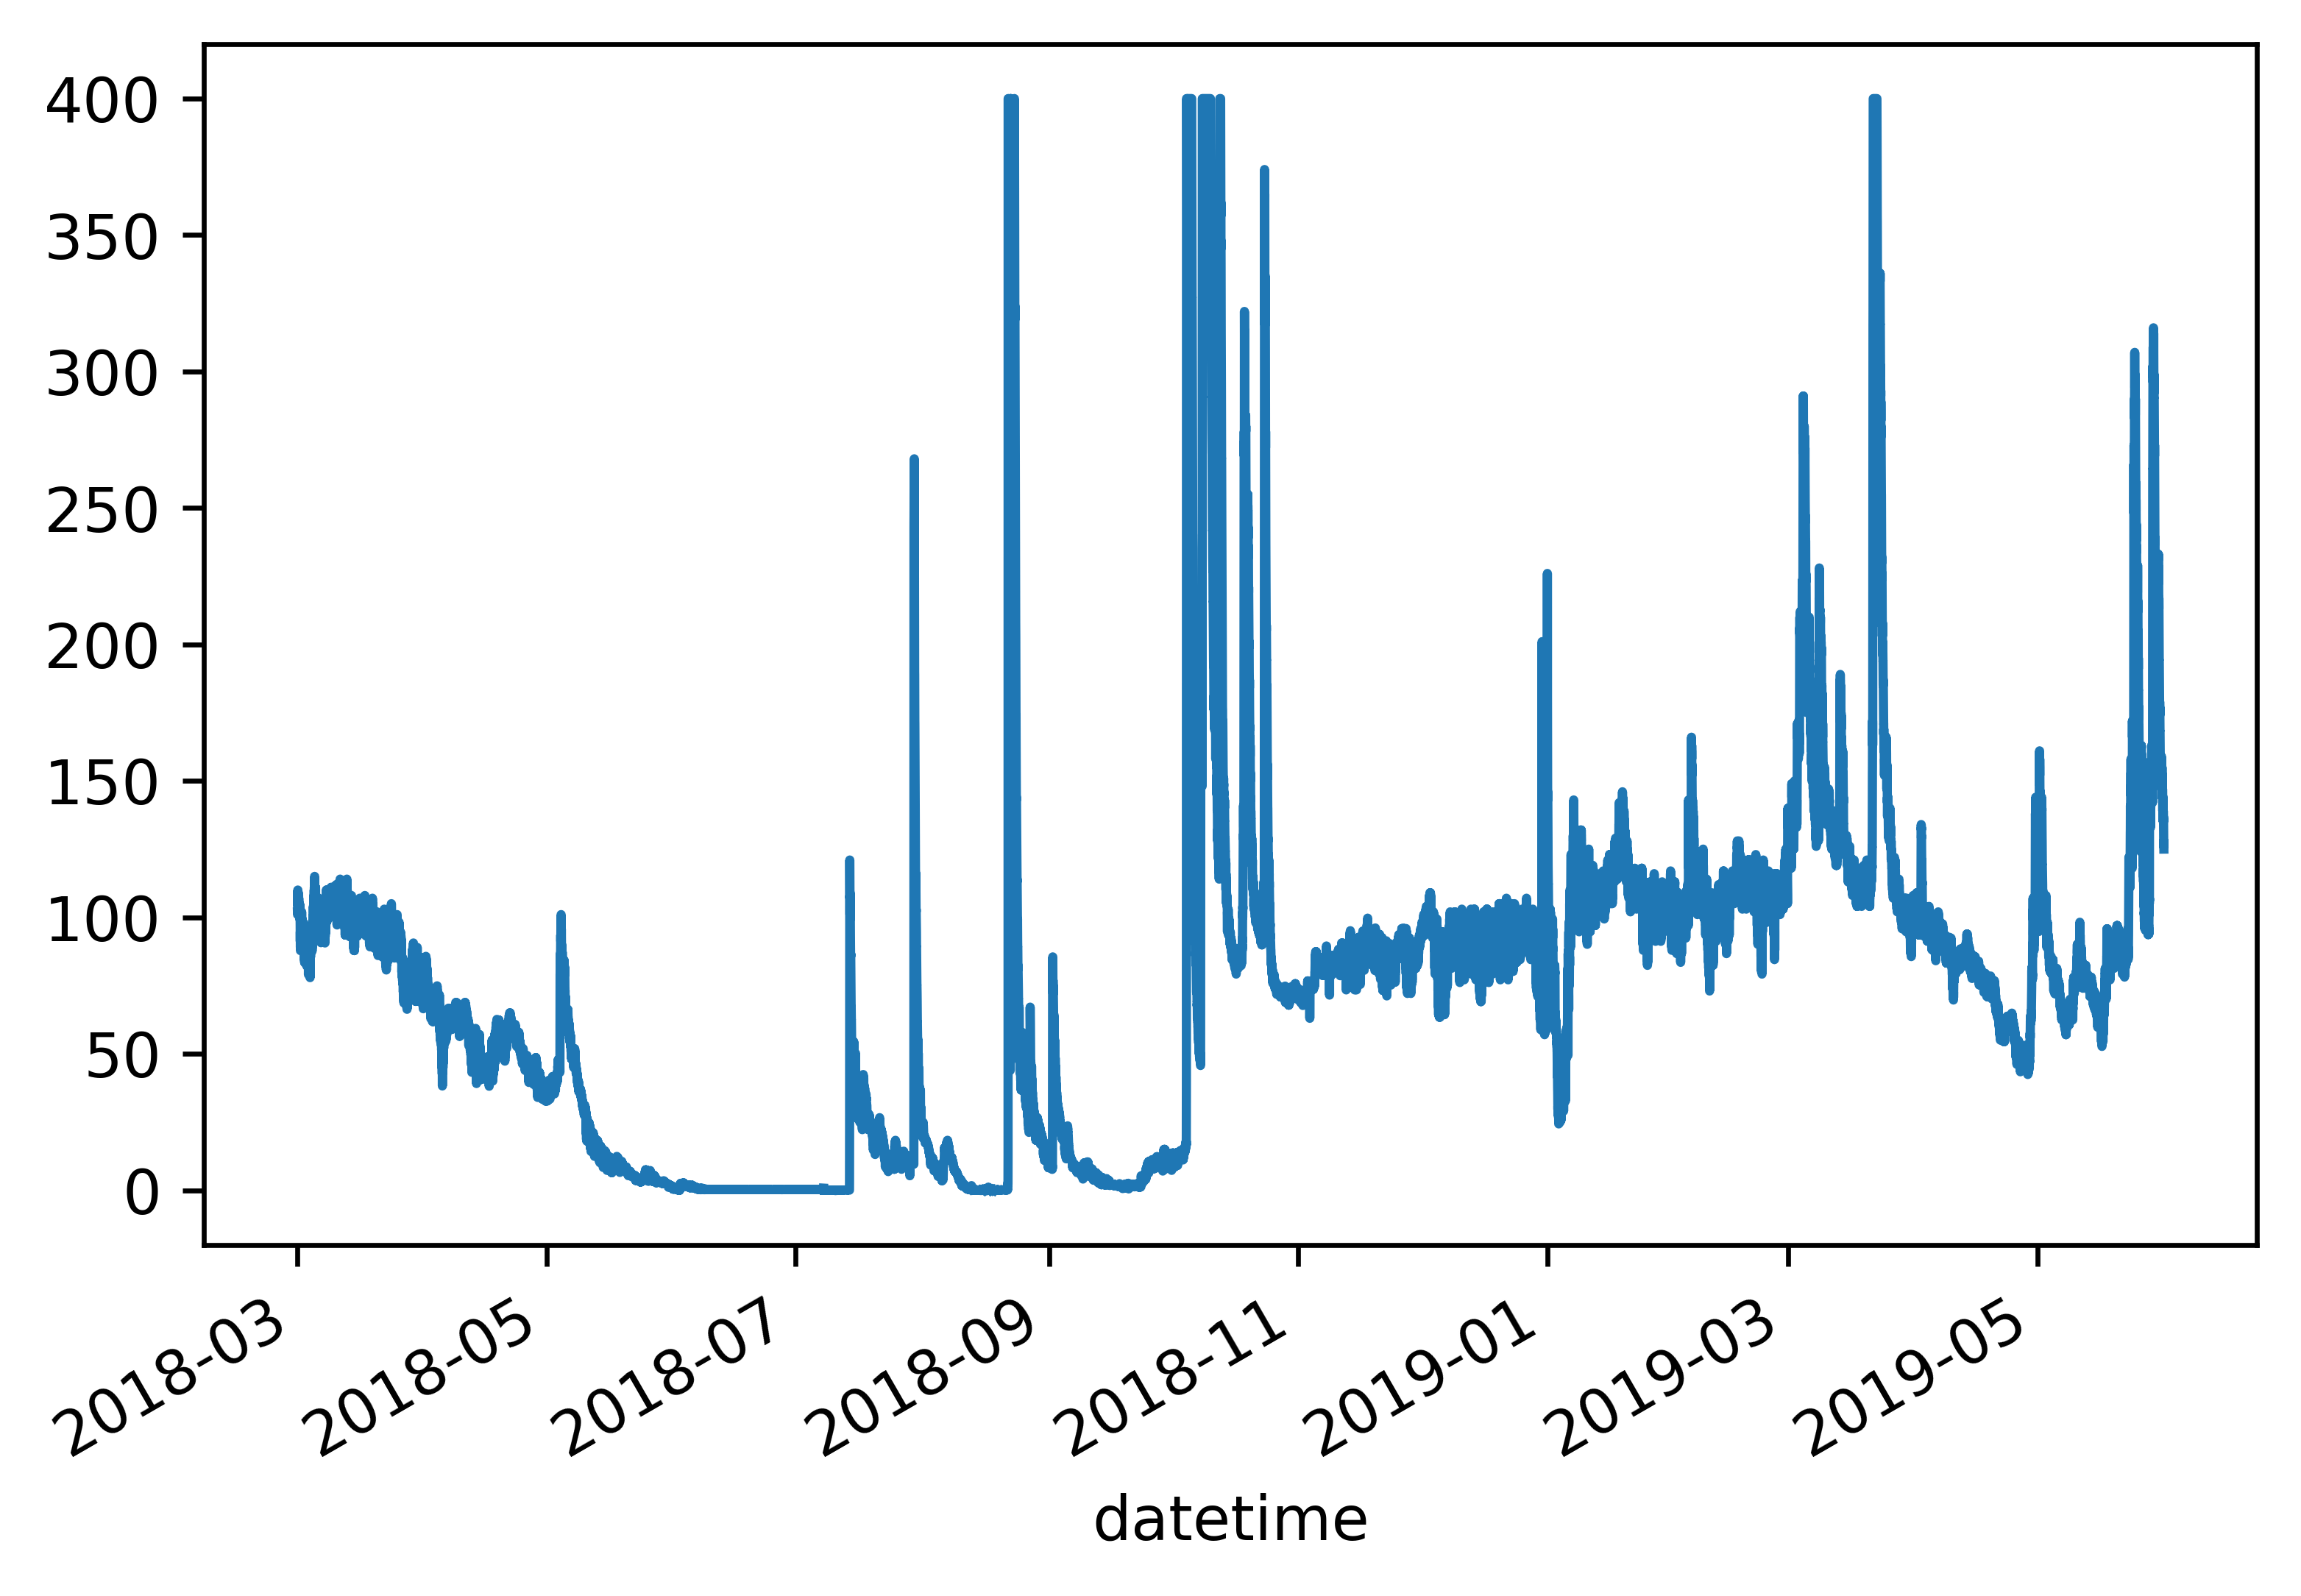

In [51]:
# Including month information
fig, ax = plt.subplots(dpi=600)
(
    cleaned_df
    ['cfs']
    # Select information from 2018/3 to 2019/5
    .loc['2018/3':'2019/5']
    # Clip at 400
    .clip(upper=400)
    # Plot this information
    .plot()
);

## Rolling Average

> Because the index is a time series, we can leverage the ability to resample. A common operation
these days is to plot rolling 7-day average data on top of daily data. The .rolling method accepts
a moving window size, window, and like a grouping operation, you generally aggregate the result.

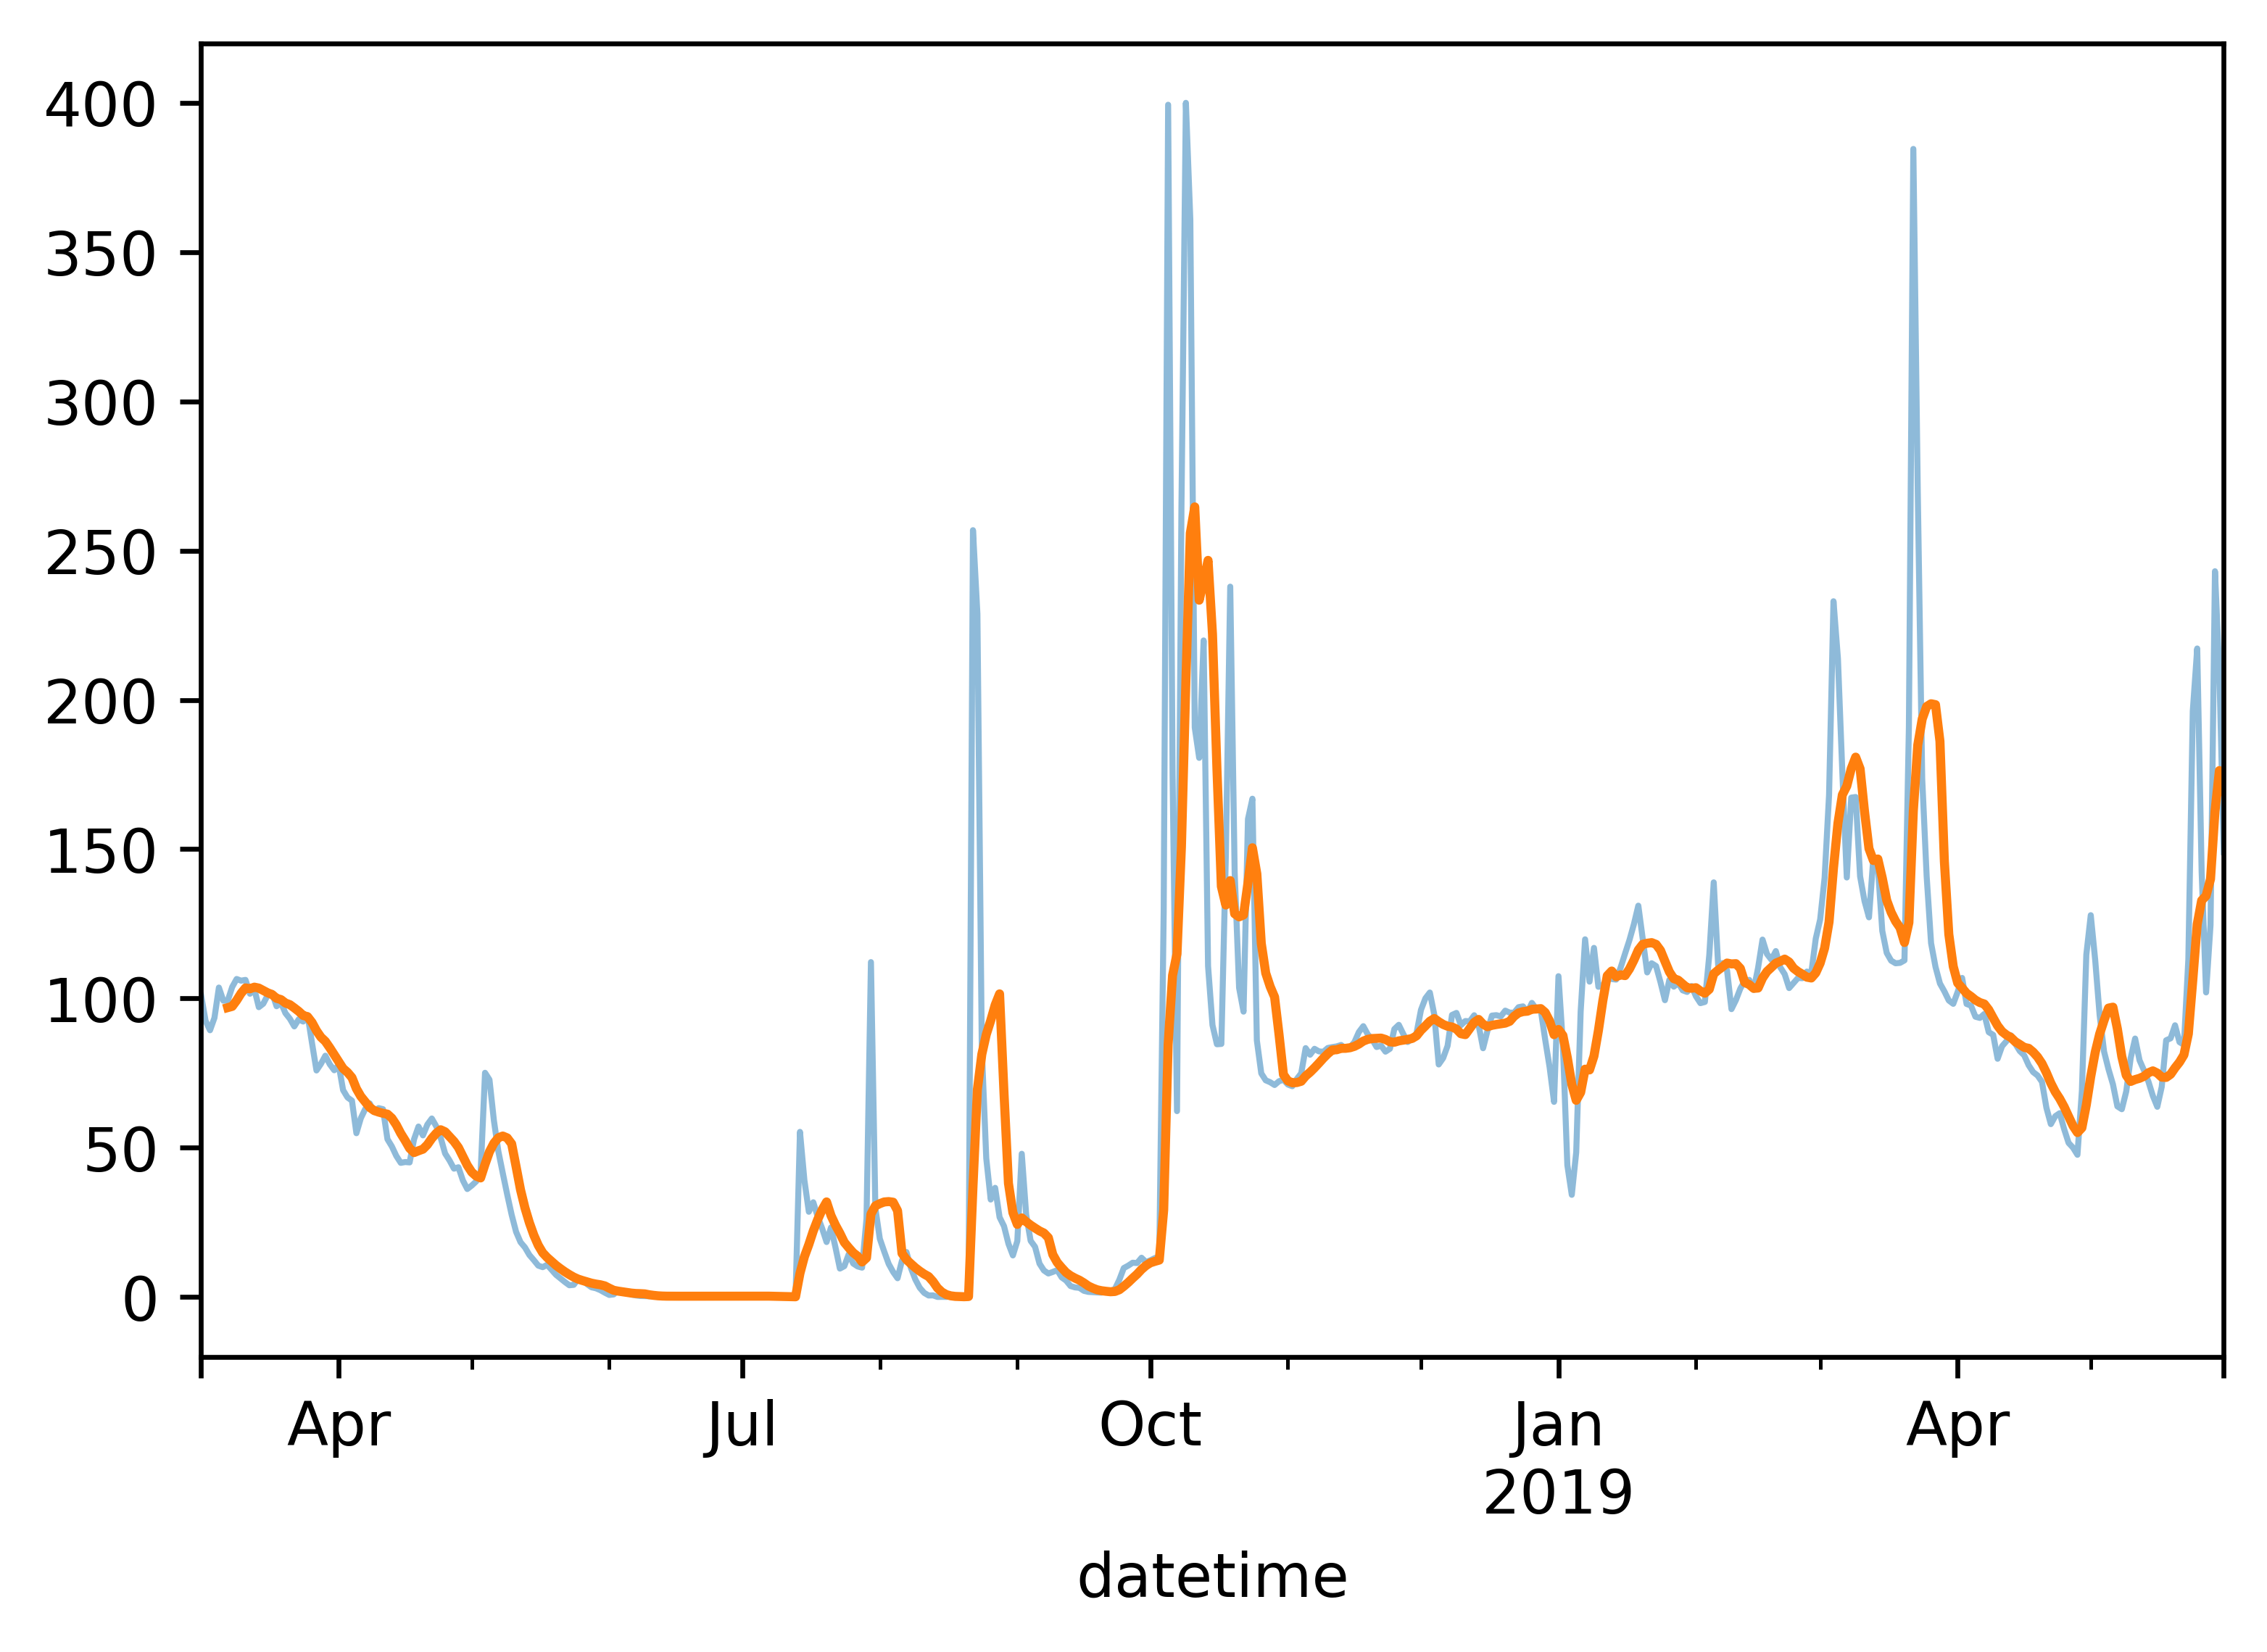

In [52]:
# Including month information
fig, ax = plt.subplots(dpi=600)


ax = (
    cleaned_df
    ['cfs']
    # Select information from 2018/3 to 2019/5
    .loc['2018/3':'2019/5']
    # clip at upper=400
    .clip(upper=400)
    # Resample
    .resample('D')
    # Find the mean
    .mean()
    .plot(alpha=0.5, linewidth=1, label='Daily')
);


ax = (
    cleaned_df
    ['cfs']
    # Select information from 2018/3 to 2019/5
    .loc['2018/3':'2019/5']
    # clip at upper=400
    .clip(upper=400)
    # Resample
    .resample('D')
    # Find the mean
    .mean()
    # Rolling average
    .rolling(7)
    .mean()
    # Plot the figure
    .plot(ax=ax, label='7-Day Rolling')
);

## Missing Time Series Data


In [53]:
(
    cleaned_df
    [['cfs']]
    .loc['2018/3':'2019/5']
    .query('cfs.isna()')
)

,cfs
datetime,
2018-07-07 19:15:00+00:00,NaN
2018-07-07 19:30:00+00:00,NaN
2018-07-07 19:45:00+00:00,NaN
2018-07-07 20:00:00+00:00,NaN
2018-07-07 20:15:00+00:00,NaN
...,...
2018-08-18 14:15:00+00:00,NaN
2018-08-18 14:30:00+00:00,NaN
2018-08-18 14:45:00+00:00,NaN


Text(0.5, 1.0, 'Missing Values Demo')

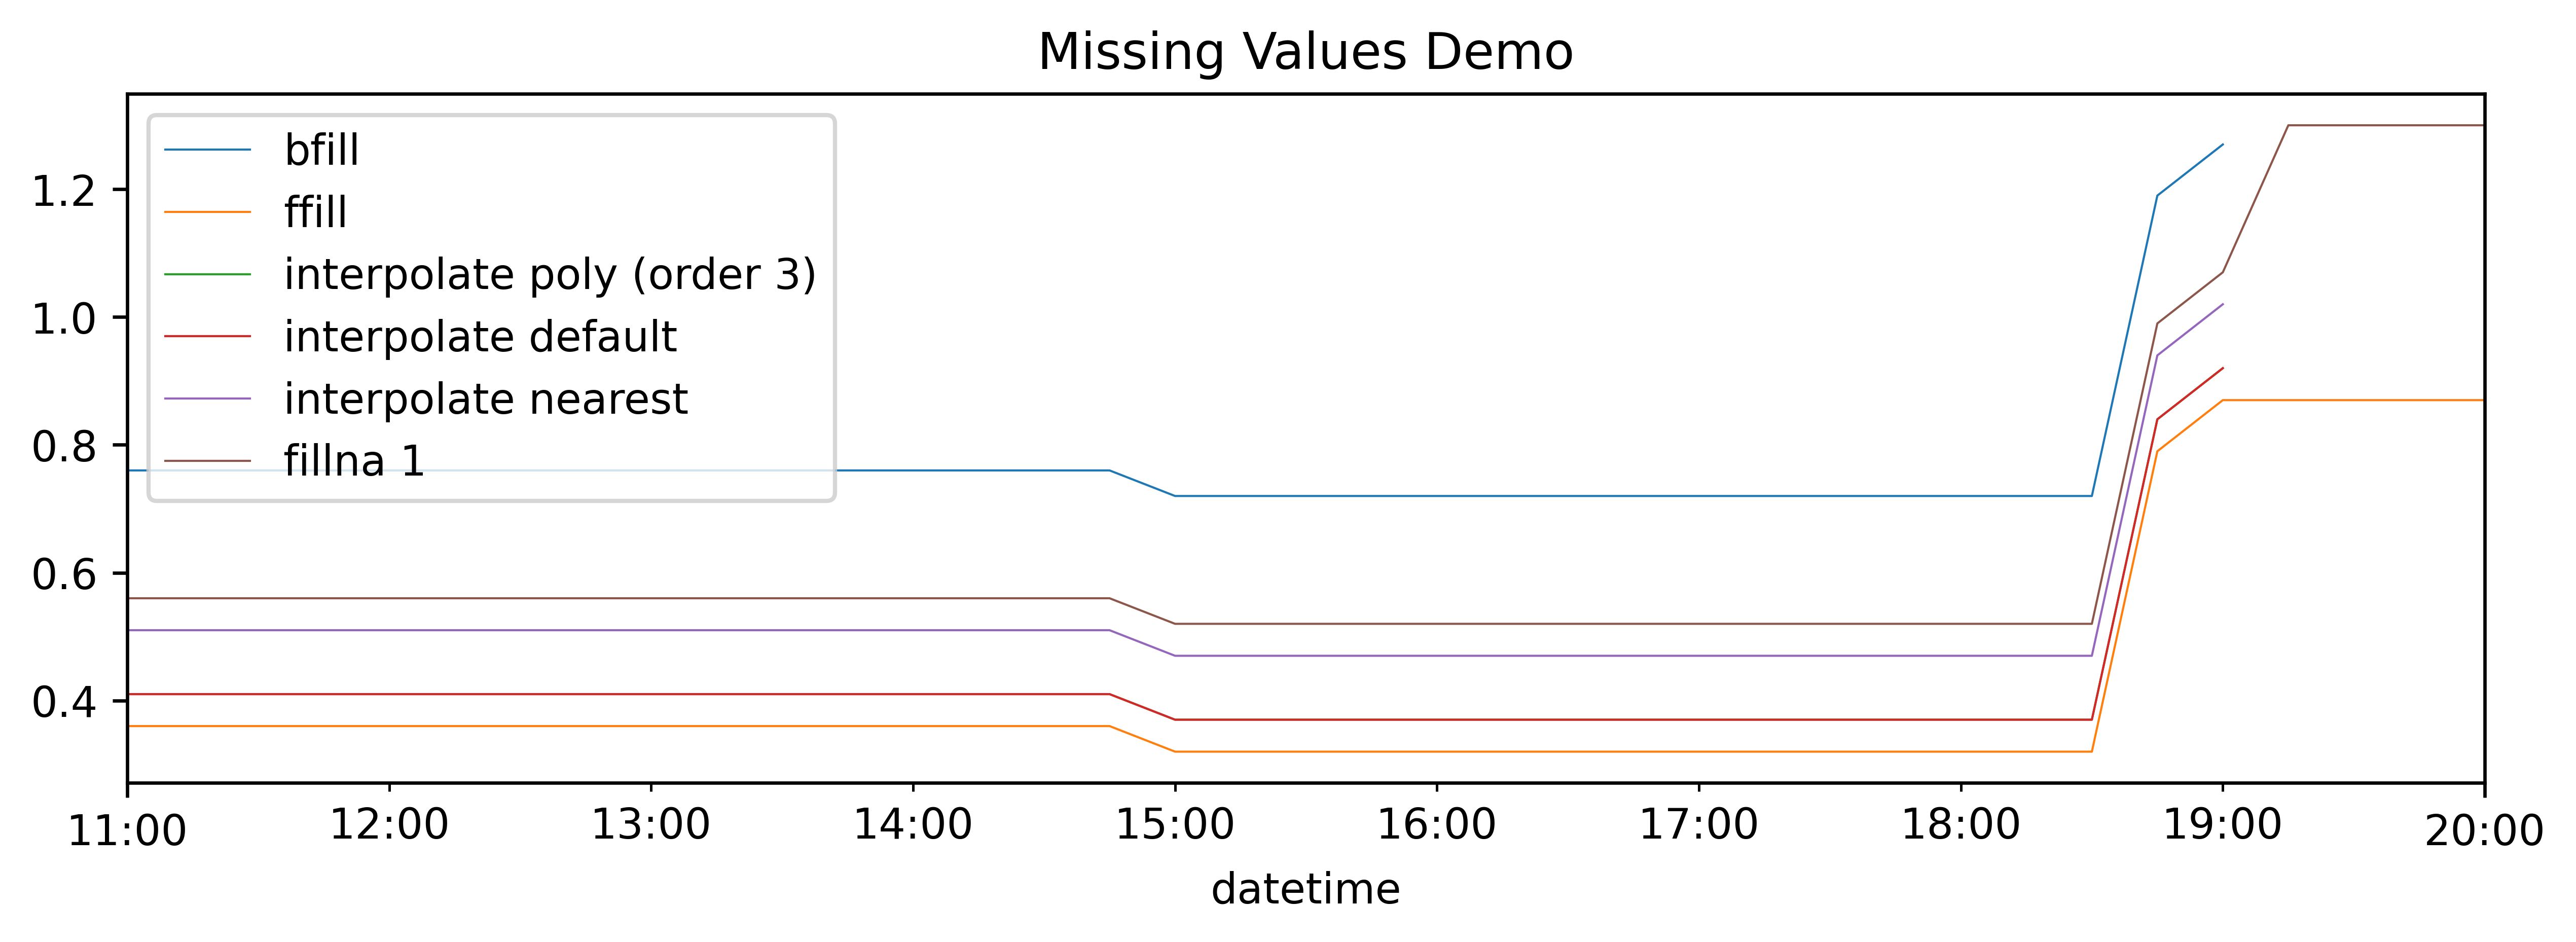

In [54]:
fig, ax = plt.subplots(dpi=600, figsize = (10, 3))

july_df = (
    cleaned_df
    ['cfs']
    .loc['2018/7/7 11:00':'2018/7/7 20:00']
)

# Original plot
(
    july_df
    # backfill missing values
    .bfill()
    # Add 0.5 tp each row
    .add(0.5)
    .plot(label='bfill', ax=ax, linewidth=0.5)
)

(
    july_df
    # frontfill missing values
    .ffill()
    # Add 0.1 tp each row
    .add(0.1)
    .plot(label='ffill', ax=ax, linewidth=0.5)
)


(
    july_df
    # Interpolate missing values
    .interpolate(method='polynomial', order=3)
    # Add 0.1 tp each row
    .add(0.15)
    .plot(label='interpolate poly (order 3)', ax=ax, linewidth=0.5)
)


(
    july_df
    # Interpolate missing values
    .interpolate()
    # Add 0.1 tp each row
    .add(0.15)
    .plot(label='interpolate default', ax=ax, linewidth=0.5)
)


(
    july_df
    # Interpolate missing values
    .interpolate(method='nearest')
    # Add 0.1 tp each row
    .add(0.25)
    .plot(label='interpolate nearest', ax=ax, linewidth=0.5)
)


(
    july_df
    # Interpolate missing values
    .fillna(1)
    # Add 0.1 tp each row
    .add(0.3)
    .plot(label='fillna 1', ax=ax, linewidth=0.5)
)

ax.legend()
ax.set_title('Missing Values Demo')

## Exploring Seasonality

Time series data may have a seasonal component to it. Let’s examine how to explore this with
pandas (and related tools). We will explore the cubic feet per second column (cfs) of the Dirty
Devil dataset. We can summarize monthly behavior in this column by combining `.groupby` and
`.describe.` Note that we already have an index with date information in it, so one might suppose
that we could use .resample with 'M' as an offset alias. However, a .resample operation will put the
end date of each month in the index, while a .grouby on the month number will have only twelve
entries in the index:

In [55]:
(
    cleaned_df
    # Convert cfs to float
    .assign(cfs = lambda df_: df_['cfs'].astype(float))
    # Groupby month
    .groupby(cleaned_df.index.month)
    # Select the cfs column
    ['cfs']
    # Describe the column
    .describe()
)

,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
1,25899.0,116.862257,28.937923,24.30,101.000,114.00,131.0,265.0
2,41169.0,126.023831,24.457867,56.00,109.000,125.00,141.0,303.0
3,51813.0,127.207295,48.804263,63.40,100.000,116.00,136.0,750.0
4,50731.0,83.029550,73.855394,20.50,53.100,70.40,98.2,2140.0
5,49483.0,63.093264,68.850791,0.49,27.800,43.90,78.8,1960.0
6,41541.0,74.414311,139.624468,0.02,9.250,32.00,84.0,2460.0
7,37044.0,62.581178,115.358223,0.00,4.230,17.05,67.8,1660.0
8,37588.0,74.809008,247.709971,0.00,6.310,25.60,59.9,7320.0
9,42247.0,128.278294,547.105484,0.00,7.445,20.00,55.0,9540.0


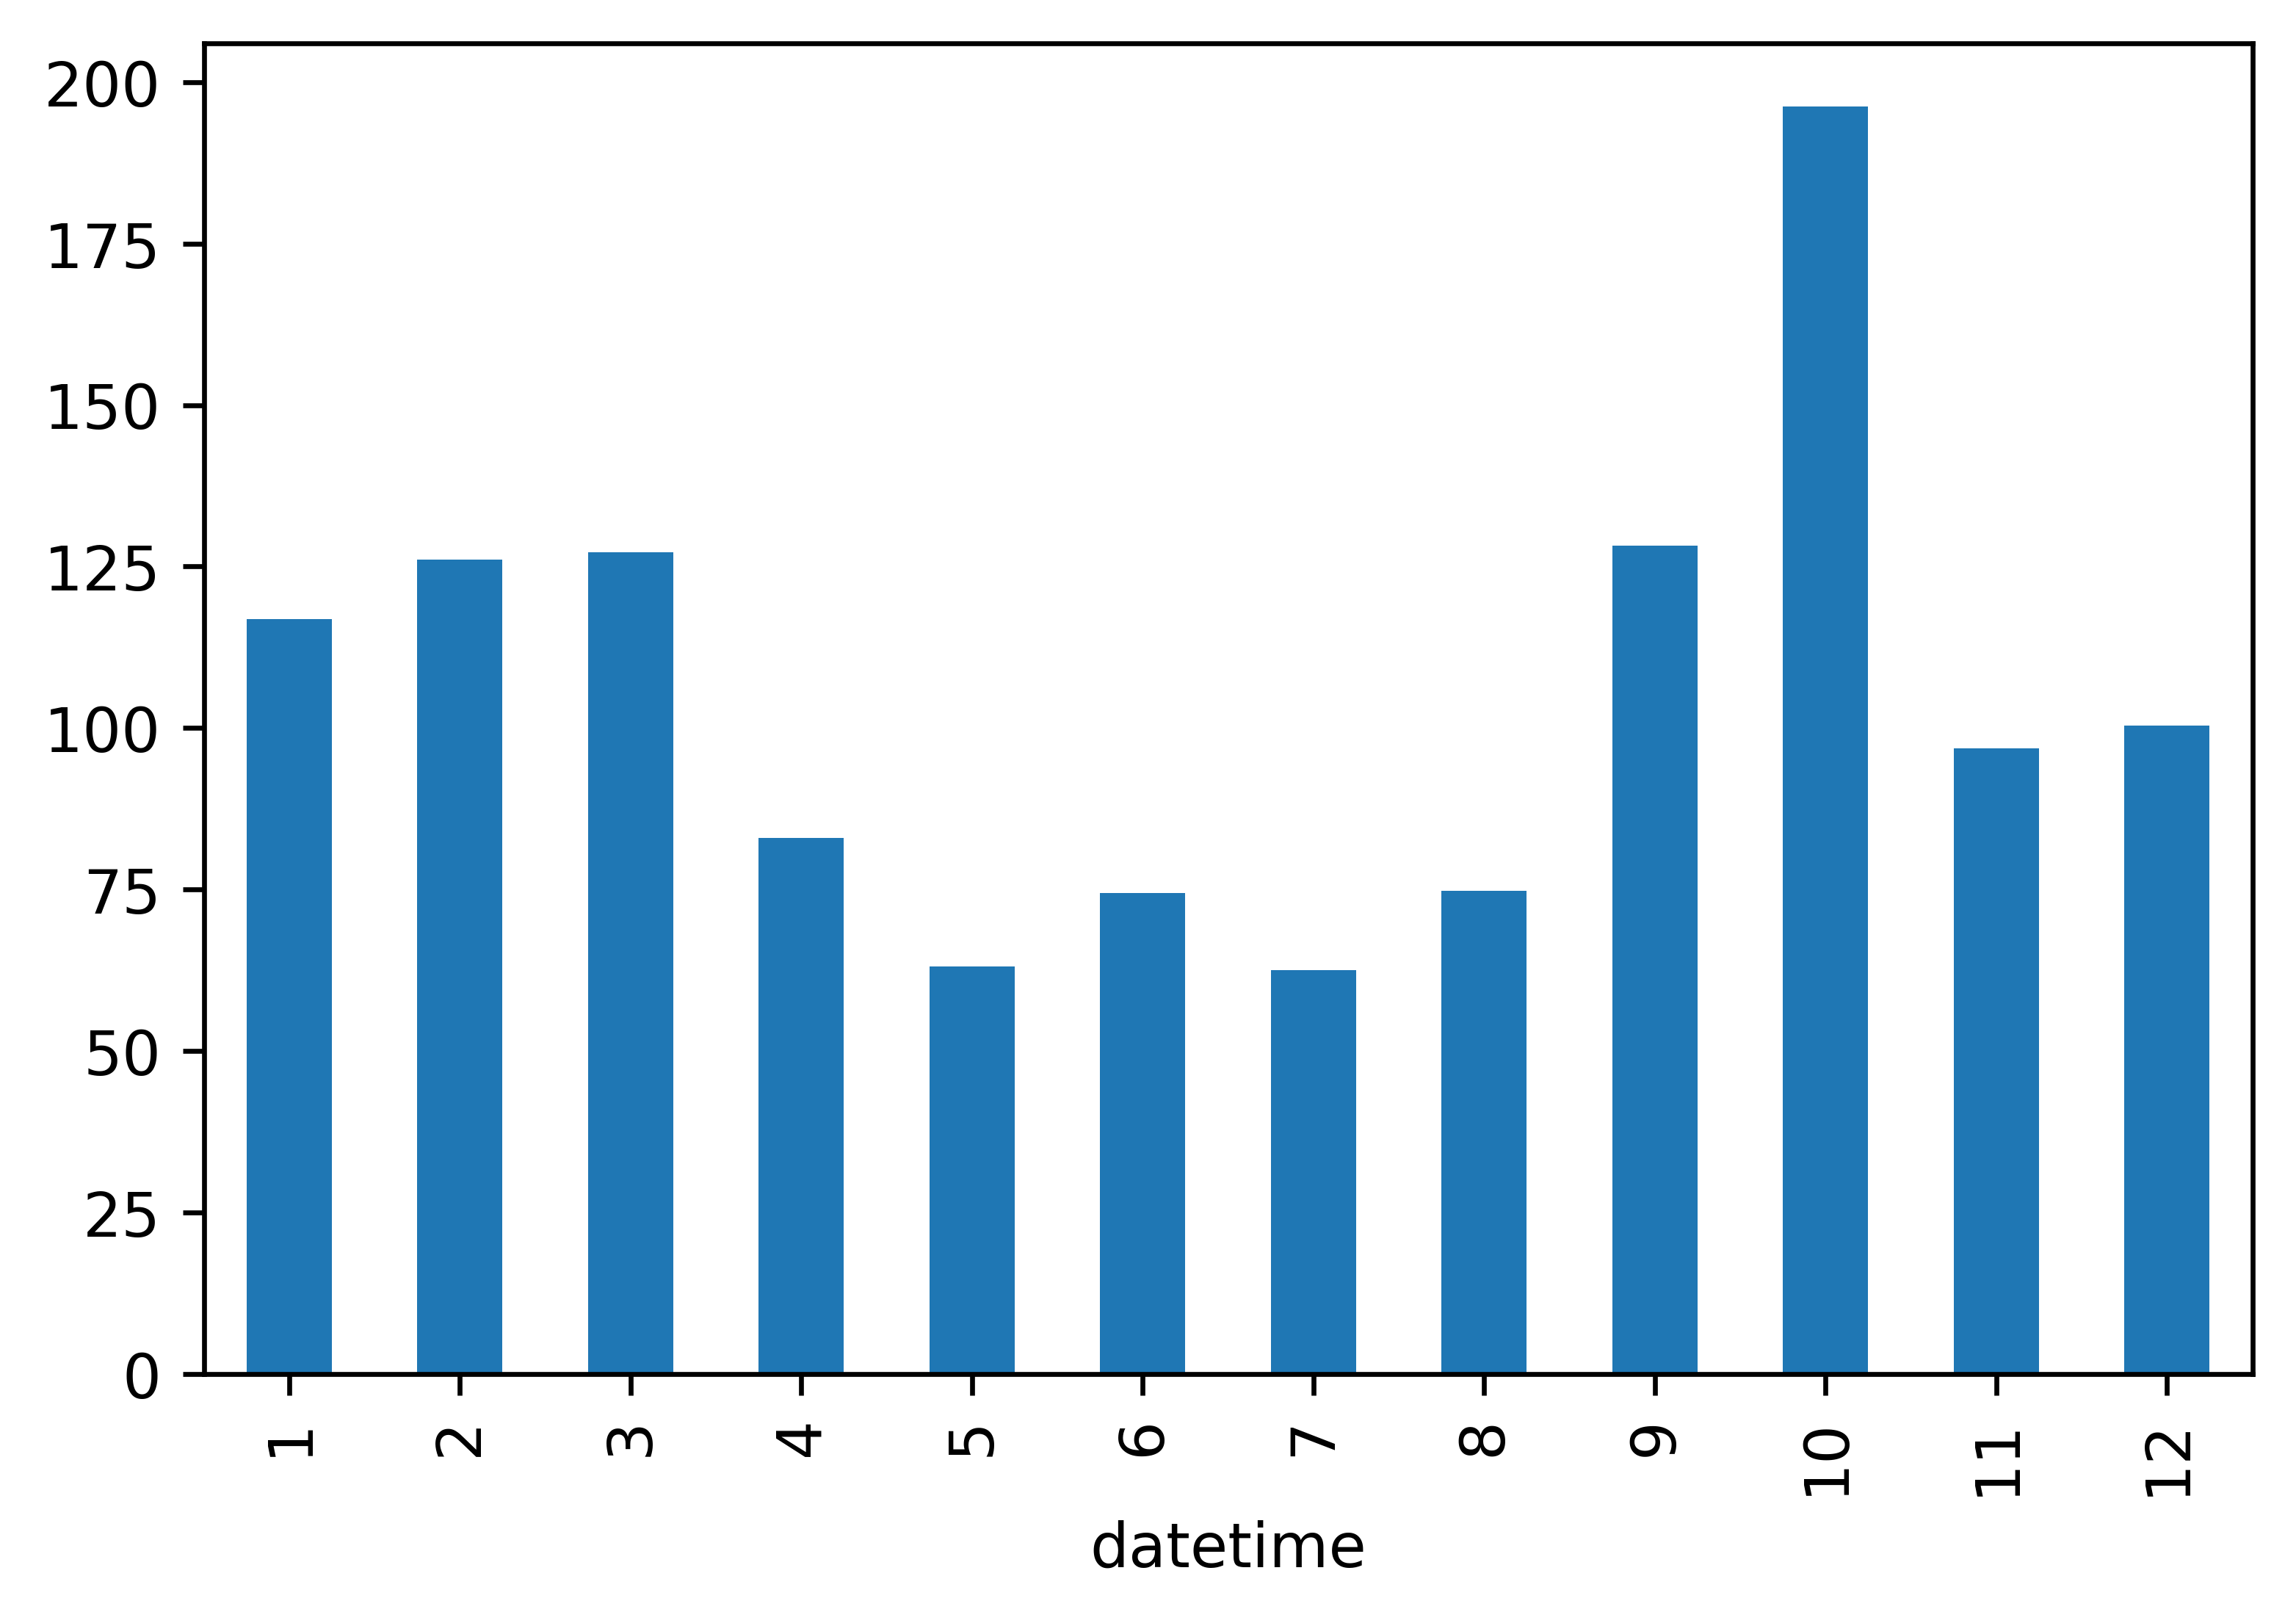

In [56]:
fig, ax = plt.subplots(dpi=600)

(
    cleaned_df
    # Convert cfs to float
    .assign(cfs = lambda df_: df_['cfs'].astype(float))
    # Groupby month
    .groupby(cleaned_df.index.month)
    # Select the cfs column
    ['cfs']
    # Describe the column
    .describe()
    # Select the mean column
    ['mean']
    # Plot a bar graph
    .plot.bar(ax=ax)
);

cfs    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

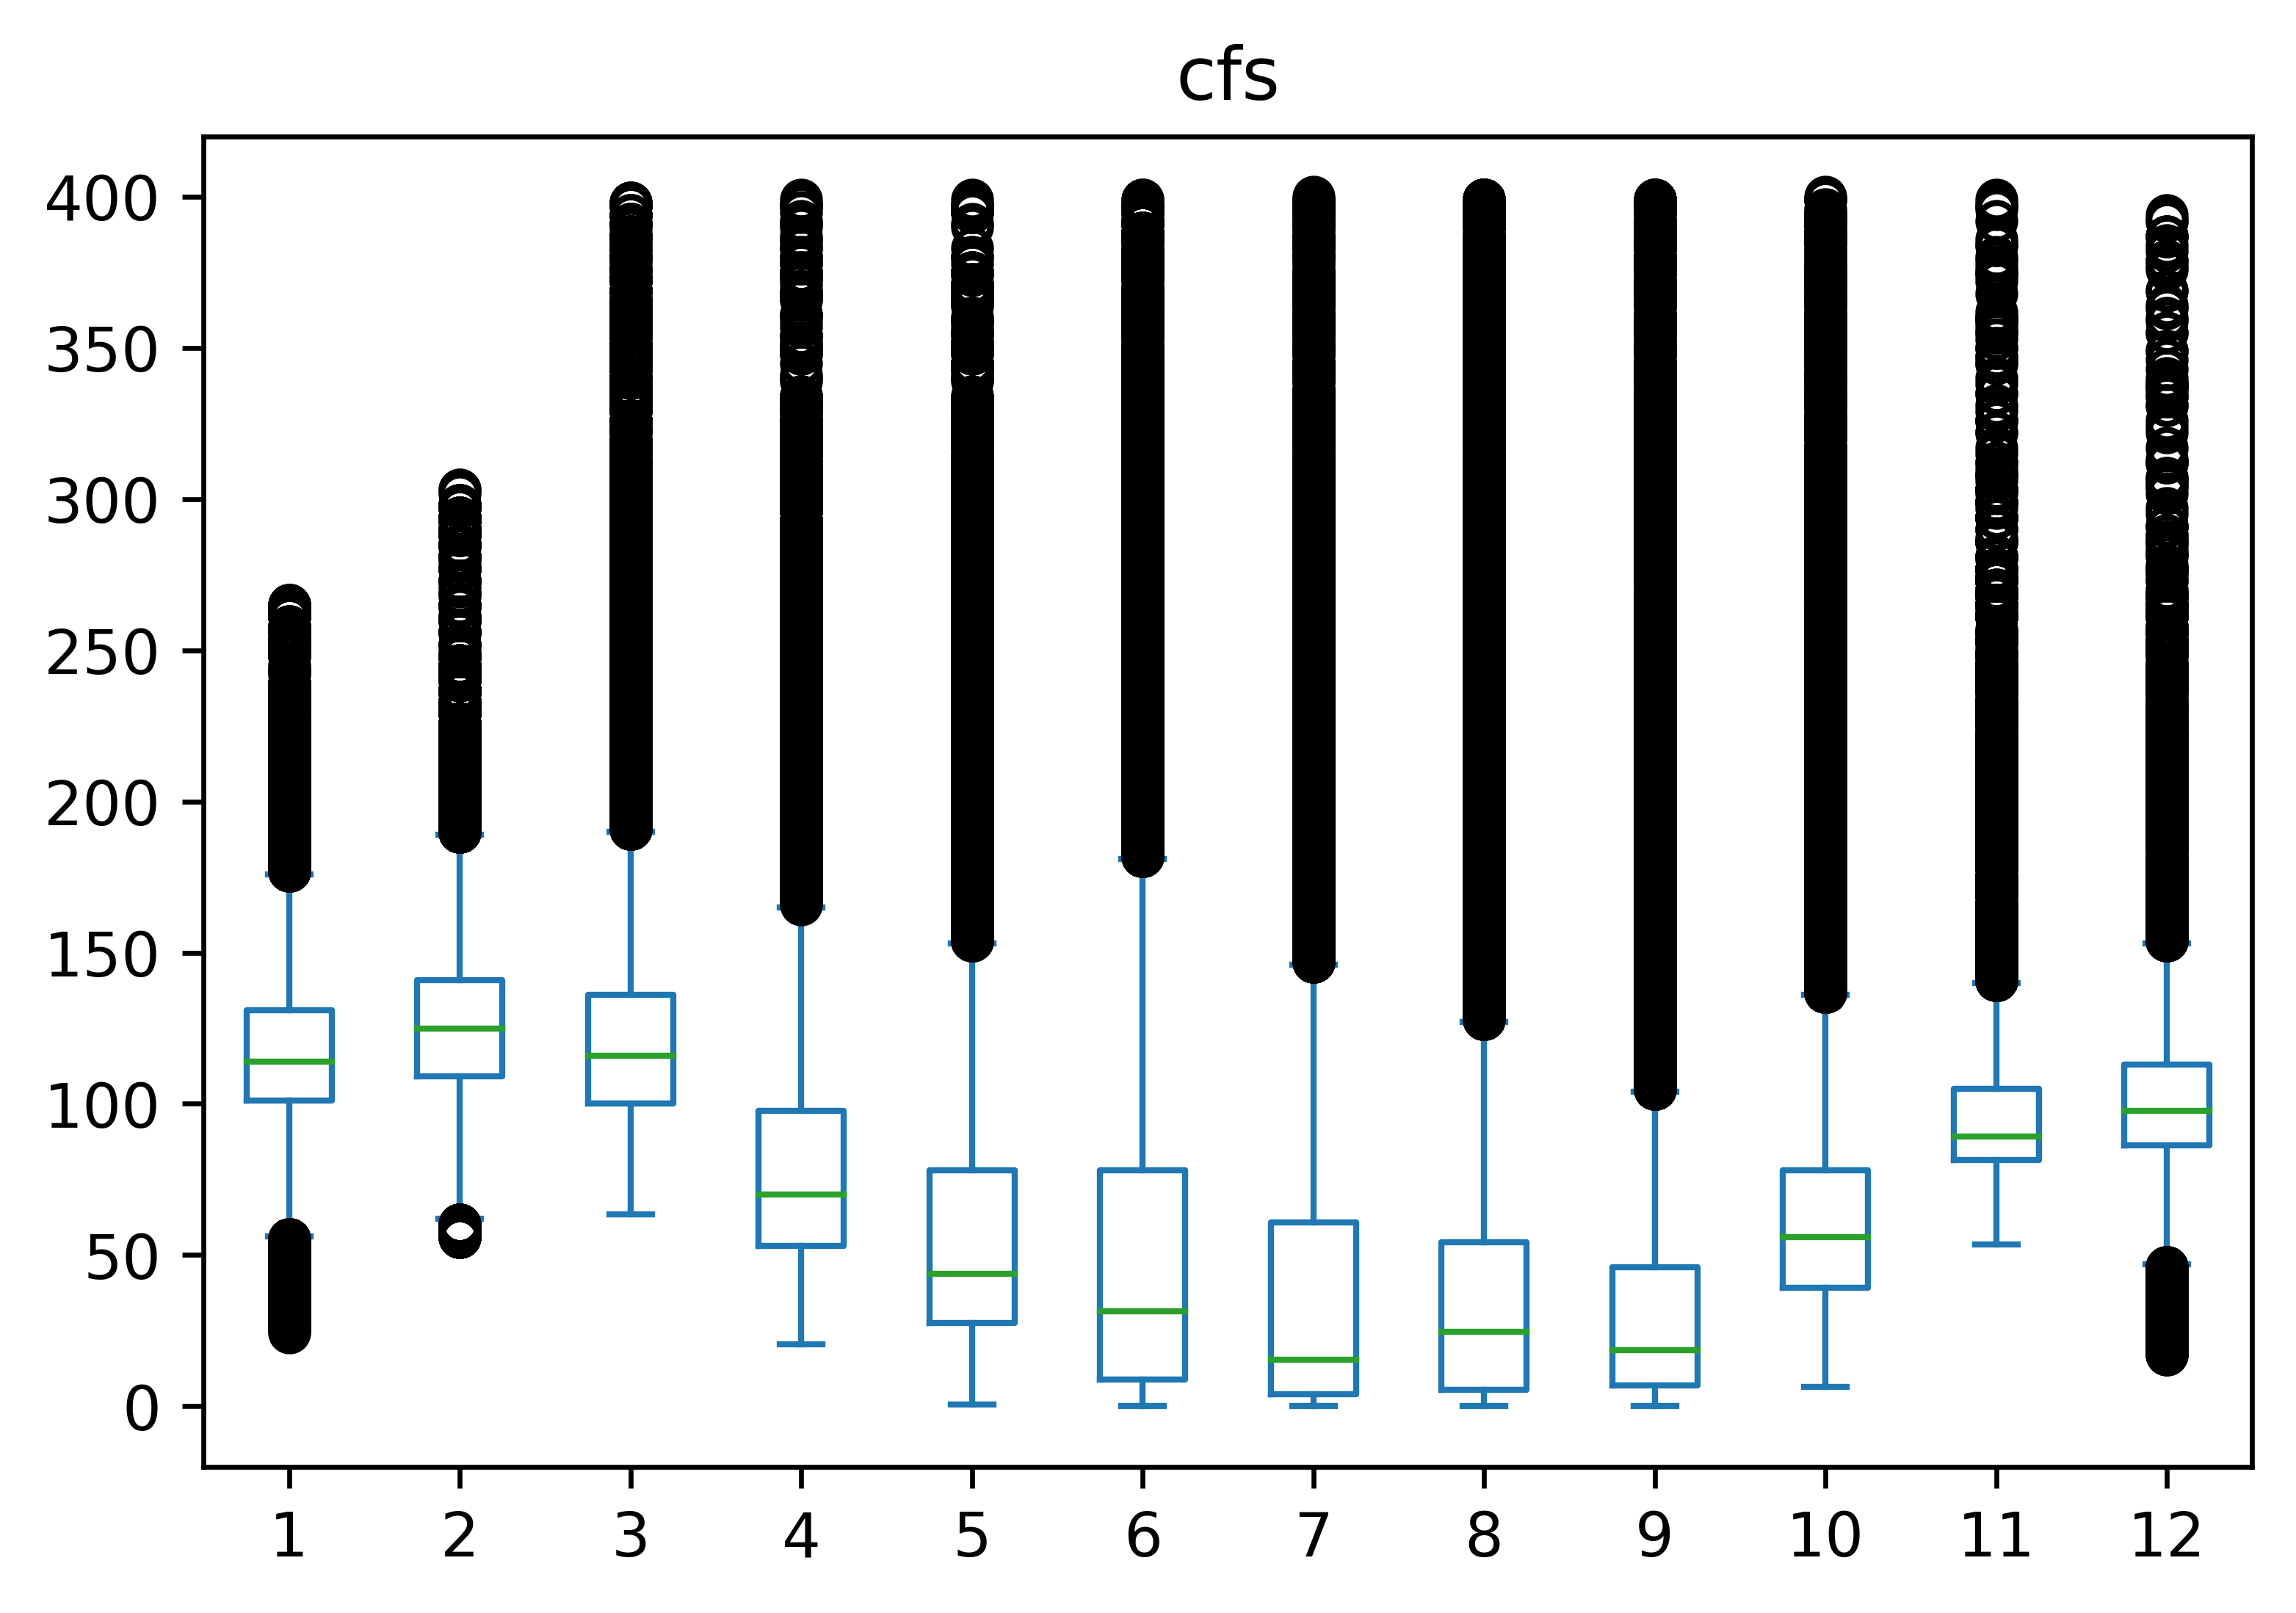

In [57]:
fig, ax = plt.subplots(dpi=600)

(
    cleaned_df
    # Convert cfs to float
    .assign(cfs = lambda df_: df_['cfs'].astype(float))
    # Create a month column
    .assign(month = cleaned_df.index.month)
    # Clip dataframe at <- 400 cfs
    .query('cfs <= 400')
    # Plot the boxplot
    .plot.box(column='cfs' ,by='month', ax=ax)
)

## Resampling Data



In [71]:
cleaned_df.head()

,agency_cd,site_no,tz_cd,cfs,144166_00060_cd,gage_height,144167_00065_cd
datetime,,,,,,,
2001-05-07 07:00:00+00:00,USGS,09333500,MDT,71.0,A:[91],NaN,NaN
2001-05-07 07:15:00+00:00,USGS,09333500,MDT,71.0,A:[91],NaN,NaN
2001-05-07 07:30:00+00:00,USGS,09333500,MDT,71.0,A:[91],NaN,NaN
2001-05-07 07:45:00+00:00,USGS,09333500,MDT,70.0,A:[91],NaN,NaN
2001-05-07 08:00:00+00:00,USGS,09333500,MDT,70.0,A:[91],NaN,NaN


> Let’s aggregate this information from a 15-minute interval to a daily interval. Because the index
has date information in it, we can use .resample in combination with 'D' (daily) as the offset alias.
I am going to use .median as the aggregation method because the flow data is heavily skewed:

In [69]:
(
    cleaned_df
    .resample('D')
    .median()
)

,site_no,cfs,gage_height
datetime,,,
2001-05-07 00:00:00+00:00,9333500.0,69.00,NaN
2001-05-08 00:00:00+00:00,9333500.0,71.00,NaN
2001-05-09 00:00:00+00:00,9333500.0,65.00,NaN
2001-05-10 00:00:00+00:00,9333500.0,55.00,NaN
2001-05-11 00:00:00+00:00,9333500.0,55.00,NaN
...,...,...,...
2020-09-24 00:00:00+00:00,9333500.0,9.20,6.15
2020-09-25 00:00:00+00:00,9333500.0,9.86,6.17
2020-09-26 00:00:00+00:00,9333500.0,10.90,6.20


> If we wanted to combine multiple days, we can do that as well by providing a numeric rule before
the alias. You can insert a number before the offset alias. In this example, we will aggregate every
two days by using '2D'.

In [70]:
(
    cleaned_df
    .resample('2D')
    .median()
)

,site_no,cfs,gage_height
datetime,,,
2001-05-07 00:00:00+00:00,9333500.0,70.000,NaN
2001-05-09 00:00:00+00:00,9333500.0,56.500,NaN
2001-05-11 00:00:00+00:00,9333500.0,54.000,NaN
2001-05-13 00:00:00+00:00,9333500.0,49.000,NaN
2001-05-15 00:00:00+00:00,9333500.0,54.000,NaN
...,...,...,...
2020-09-20 00:00:00+00:00,9333500.0,6.560,6.060
2020-09-22 00:00:00+00:00,9333500.0,7.535,6.095
2020-09-24 00:00:00+00:00,9333500.0,9.530,6.160


## Combining Offset Aliases

We can also combine offset aliases. If we want to aggregate at the three-day, 2-hour and 10-minute
interval, we can combine all of these rules with the offset aliases into a single string:

In [72]:
(
    cleaned_df
    .resample('3D2H10min')
    .median()
)

,site_no,cfs,gage_height
datetime,,,
2001-05-07 00:00:00+00:00,9333500.0,68.00,NaN
2001-05-10 02:10:00+00:00,9333500.0,55.00,NaN
2001-05-13 04:20:00+00:00,9333500.0,49.00,NaN
2001-05-16 06:30:00+00:00,9333500.0,51.00,NaN
2001-05-19 08:40:00+00:00,9333500.0,47.00,NaN
...,...,...,...
2020-09-14 13:20:00+00:00,9333500.0,5.79,6.03
2020-09-17 15:30:00+00:00,9333500.0,5.79,6.03
2020-09-20 17:40:00+00:00,9333500.0,7.11,6.08


## Anchored Offset Aliases

Some of the frequencies in offset aliases allow you to modify when the window for the frequency
ends. You can use this operation on the weekly, quarterly, and yearly frequencies. Note that the
default quarter ends in March, June, September, and December:

In [73]:
(
    cleaned_df
    # Resample Quarterly
    .resample('Q')
    .median()
)

,site_no,cfs,gage_height
datetime,,,
2001-06-30 00:00:00+00:00,9333500.0,45.00,NaN
2001-09-30 00:00:00+00:00,9333500.0,27.00,NaN
2001-12-31 00:00:00+00:00,9333500.0,85.00,NaN
2002-03-31 00:00:00+00:00,9333500.0,122.00,NaN
2002-06-30 00:00:00+00:00,9333500.0,46.00,NaN
...,...,...,...
2019-09-30 00:00:00+00:00,9333500.0,13.40,6.21
2019-12-31 00:00:00+00:00,9333500.0,91.80,6.75
2020-03-31 00:00:00+00:00,9333500.0,126.00,6.99


In [74]:
(
    cleaned_df
    # We can tack on -JAN to force the quarters to end in January, April, July, and October:
    .resample('Q-JAN')
    .median()
)

,site_no,cfs,gage_height
datetime,,,
2001-07-31 00:00:00+00:00,9333500.0,42.00,NaN
2001-10-31 00:00:00+00:00,9333500.0,39.00,NaN
2002-01-31 00:00:00+00:00,9333500.0,116.00,NaN
2002-04-30 00:00:00+00:00,9333500.0,96.00,NaN
2002-07-31 00:00:00+00:00,9333500.0,13.00,NaN
...,...,...,...
2019-10-31 00:00:00+00:00,9333500.0,12.80,6.25
2020-01-31 00:00:00+00:00,9333500.0,116.00,6.84
2020-04-30 00:00:00+00:00,9333500.0,117.00,6.98


## Resampling Finer Grain

In [76]:
(
    cleaned_df
    .resample('30min')
    .median()
    # Interpolate missing values
    .interpolate()
)

,site_no,cfs,gage_height
datetime,,,
2001-05-07 07:00:00+00:00,9333500.0,71.000,NaN
2001-05-07 07:30:00+00:00,9333500.0,70.500,NaN
2001-05-07 08:00:00+00:00,9333500.0,69.500,NaN
2001-05-07 08:30:00+00:00,9333500.0,70.000,NaN
2001-05-07 09:00:00+00:00,9333500.0,70.000,NaN
...,...,...,...
2020-09-28 13:30:00+00:00,9333500.0,9.365,6.155
2020-09-28 14:00:00+00:00,9333500.0,9.365,6.155
2020-09-28 14:30:00+00:00,9333500.0,9.365,6.155
